In [1]:
!nvidia-smi

Thu Jun 27 03:07:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
|  0%   43C    P8               8W / 320W |     86MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!pip install wandb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 628.9 kB/s eta 0:00:0000:01


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, TrainingArguments, Trainer
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import Levenshtein as lev
from datasets import load_metric
from transformers import get_linear_schedule_with_warmup, AdamW
import wandb
# Login to wandb
wandb.login(key="cd2121ac29916b58f19853bee99f7fbdc3187ca4")

# Initialize wandb project
wandb.init(project="trocr-ocr-finetuning")
class SpanishDocumentsDataset(Dataset):
    def __init__(self, image_dir, text_dir, processor):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.processor = processor
        self.filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_file = self.filenames[idx]
        # Derive the corresponding text file name by changing the extension
        text_file = image_file.replace('.jpg', '.txt')
        
        image_path = os.path.join(self.image_dir, image_file)
        text_path = os.path.join(self.text_dir, text_file)
        
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()

        with open(text_path, 'r', encoding='utf-8') as file:
            text = file.read().strip()
        labels = self.processor.tokenizer(text, return_tensors="pt").input_ids.squeeze()
        
        # Treat padding specially for label calculation, if necessary
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {"pixel_values": pixel_values, "labels": labels}



image_dir = 'dataset/All_line_segments'
text_dir = 'dataset/All_line_texts'

def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Padding value for labels should be -100 to ignore tokens during loss calculation
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    pixel_values = torch.stack(pixel_values)
    
    return {"pixel_values": pixel_values, "labels": labels}



# Initialize processor and model with correct configurations
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.ignore_pad_token_for_loss = True  # Ensure pad tokens are ignored during loss calculation

# Prepare dataset and data loader
dataset = SpanishDocumentsDataset(image_dir, text_dir, processor=processor)

dataset_size = len(dataset)
eval_size = int(dataset_size * 0.1)  # 10% for evaluation
train_size = dataset_size - eval_size  # Remaining for training

# Split the dataset
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=8, collate_fn=collate_fn)



Matplotlib is building the font cache; this may take a moment.
wandb: Currently logged in as: utsavrai (gsoc24_utsavrai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/ur23/.netrc


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
# # To see how the data is loaded, let's fetch a batch from the DataLoader
print(len(train_loader))
for batch in train_loader:
    print(batch['pixel_values'].shape, batch['labels'].shape)
    break  # Just show the first batch for demonstration

165
torch.Size([8, 3, 384, 384]) torch.Size([8, 18])


In [5]:
import Levenshtein as lev

def compute_cer(decoded_preds, decoded_labels):
    """
    Compute the Character Error Rate (CER).
    CER is defined as the edit distance between the predicted and true sequences
    divided by the length of the true sequence.
    """
    total_edit_distance = 0
    total_length = 0
    
    for pred, label in zip(decoded_preds, decoded_labels):
        total_edit_distance += lev.distance(pred, label)
        total_length += len(label)
    
    cer = total_edit_distance / total_length if total_length > 0 else 0
    return cer

def compute_wer(decoded_preds, decoded_labels):
    """
    Compute the Word Error Rate (WER).
    WER is defined as the edit distance between the predicted and true sequences
    of words divided by the number of words in the true sequence.
    """
    total_edit_distance = 0
    total_words = 0
    
    for pred, label in zip(decoded_preds, decoded_labels):
        pred_words = pred.split()
        label_words = label.split()
        
        total_edit_distance += lev.distance(pred_words, label_words)
        total_words += len(label_words)
    
    wer = total_edit_distance / total_words if total_words > 0 else 0
    return wer


In [5]:
!pip install optuna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import optuna
from evaluate import load
from transformers import get_linear_schedule_with_warmup, AdamW, TrainingArguments, Trainer

# Load metrics using the new evaluate library
cer_metric = load("cer", trust_remote_code=True)
wer_metric = load("wer", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    predictions = logits.argmax(-1)
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = []
    for label in labels:
        label_filtered = [token for token in label if token != -100]
        decoded_label = processor.decode(label_filtered, skip_special_tokens=True)
        decoded_labels.append(decoded_label)
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    wer = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"cer": cer, "wer": wer}

def model_training(trial):
    # Reinitialize the model for each trial
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
    model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.config.eos_token_id = processor.tokenizer.eos_token_id
    model.config.ignore_pad_token_for_loss = True

    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 1000)

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir="model/trocr_finetuned",
        per_device_train_batch_size=4,  # Keeping it fixed due to GPU limitation
        gradient_accumulation_steps=1,
        num_train_epochs=2,
        max_grad_norm=1.0,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="steps",
        eval_steps=25,
        save_steps=25,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        save_total_limit=1,
        load_best_model_at_end=True,
        report_to="wandb",
    )

    total_train_steps = (len(train_dataset) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
    
    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_train_steps)
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        optimizers=(optimizer, scheduler),
        data_collator=collate_fn,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    eval_results = trainer.evaluate()
    
    # Use WER as the objective value for optimization
    return eval_results["eval_wer"]

# Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(model_training, n_trials=20)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-06-27 03:11:17,085] A new study created in memory with name: no-name-83c3285d-9f60-40fc-94e9-c0fa908e1f3d
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/vol/bitbucket/

Step,Training Loss,Validation Loss,Cer,Wer
25,5.934900,6.001505,0.407619,0.784512
50,5.558200,5.744740,0.389206,0.764310
75,5.043100,5.348174,0.359577,0.744108
100,5.022600,4.820144,0.337778,0.726150
125,4.429600,3.971672,0.327407,0.708193
150,3.596800,3.283917,0.314709,0.679012
175,2.895600,2.618151,0.302011,0.641975
200,2.208600,1.922799,0.264762,0.590348
225,1.650800,1.222103,0.176720,0.420875
250,0.846200,0.892225,0.125926,0.331089


Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 03:45:58,491] Trial 0 finished with value: 0.12906846240179573 and parameters: {'learning_rate': 1.2475006484023944e-06, 'weight_decay': 0.05205030051211975, 'warmup_steps': 524}. Best is trial 0 with value: 0.12906846240179573.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarn

Step,Training Loss,Validation Loss,Cer,Wer
25,5.232100,4.421110,0.333122,0.720539
50,2.321200,1.966300,0.270265,0.592593
75,0.799000,0.649668,0.096931,0.249158
100,0.618100,0.437385,0.069206,0.178451
125,0.374300,0.394473,0.059471,0.163861
150,0.456400,0.372702,0.058836,0.175084
175,0.445600,0.323833,0.050370,0.134680
200,0.305200,0.295382,0.044656,0.139169
225,0.460800,0.301266,0.057354,0.150393
250,0.310600,0.335154,0.053122,0.157127


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 04:19:34,928] Trial 1 finished with value: 0.08641975308641975 and parameters: {'learning_rate': 1.4354076445060036e-05, 'weight_decay': 0.26741048956914826, 'warmup_steps': 289}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarn

Step,Training Loss,Validation Loss,Cer,Wer
25,5.706300,5.511441,0.365714,0.748597
50,4.016500,3.927028,0.324021,0.699214
75,2.669600,2.409253,0.297778,0.634119
100,1.365200,0.943981,0.144127,0.360269
125,0.700900,0.594014,0.088042,0.233446
150,0.539700,0.486689,0.075132,0.205387
175,0.514400,0.409718,0.062857,0.171717
200,0.402000,0.391204,0.063492,0.170595
225,0.547000,0.349357,0.060317,0.152637
250,0.301200,0.346730,0.055026,0.147026


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 04:53:00,771] Trial 2 finished with value: 0.0920314253647587 and parameters: {'learning_rate': 8.361469855857607e-06, 'weight_decay': 0.02002135256557843, 'warmup_steps': 493}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarnin

Step,Training Loss,Validation Loss,Cer,Wer
25,5.466300,4.963738,0.344762,0.737374
50,2.949000,2.685408,0.307725,0.638608
75,1.355700,0.848191,0.128042,0.324355
100,0.743300,0.547535,0.081270,0.215488
125,0.465200,0.424331,0.060952,0.171717
150,0.483100,0.401160,0.058836,0.169473
175,0.453000,0.327498,0.049735,0.144781
200,0.335800,0.315903,0.048889,0.130191
225,0.491100,0.320496,0.049312,0.135802
250,0.345200,0.327240,0.049735,0.145903


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 05:26:10,254] Trial 3 finished with value: 0.14590347923681257 and parameters: {'learning_rate': 2.0699727381972257e-05, 'weight_decay': 0.1130758114385716, 'warmup_steps': 621}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarni

Step,Training Loss,Validation Loss,Cer,Wer
25,5.916400,5.957909,0.404021,0.778900
50,5.419800,5.559547,0.371852,0.758698
75,4.742900,4.993971,0.342434,0.740741
100,4.442600,4.098547,0.322328,0.703704
125,3.553200,3.245326,0.322328,0.682379
150,2.696300,2.479924,0.299048,0.626263
175,2.069500,1.646600,0.244233,0.558923
200,1.218300,0.982171,0.146878,0.367003
225,0.986500,0.759576,0.109206,0.288440
250,0.530800,0.641907,0.089524,0.235690


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 05:59:18,617] Trial 4 finished with value: 0.1335578002244669 and parameters: {'learning_rate': 1.1600128278464434e-06, 'weight_decay': 0.2285296739482484, 'warmup_steps': 322}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarnin

Step,Training Loss,Validation Loss,Cer,Wer
25,5.931200,5.992942,0.404656,0.780022
50,5.528900,5.705060,0.382857,0.760943
75,4.988400,5.266902,0.353862,0.741863
100,4.879100,4.606182,0.331852,0.727273
125,4.085700,3.745452,0.321481,0.705948
150,3.308600,3.090567,0.316190,0.672278
175,2.746900,2.411424,0.286561,0.622896
200,1.991200,1.683303,0.250794,0.569024
225,1.420100,1.034842,0.151958,0.369248
250,0.717500,0.793217,0.114921,0.304153


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 06:32:23,526] Trial 5 finished with value: 0.122334455667789 and parameters: {'learning_rate': 2.282549859774316e-06, 'weight_decay': 0.12074612840314654, 'warmup_steps': 868}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning

Step,Training Loss,Validation Loss,Cer,Wer
25,4.635200,3.397817,0.326349,0.681257
50,1.079800,0.716363,0.110053,0.295174
75,0.551300,0.494811,0.069841,0.198653
100,0.517400,0.382602,0.055450,0.152637
125,0.394200,0.412162,0.075767,0.187430
150,0.431900,0.487570,0.098624,0.254770
175,0.493900,0.453245,0.072169,0.196409
200,0.446700,0.476223,0.096085,0.206510
225,0.639100,0.953830,0.155344,0.310887
250,0.604300,0.832360,0.174815,0.297419


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 07:05:57,172] Trial 6 finished with value: 0.12008978675645342 and parameters: {'learning_rate': 2.739657253072492e-05, 'weight_decay': 0.22921220454542046, 'warmup_steps': 272}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarni

Step,Training Loss,Validation Loss,Cer,Wer
25,5.516100,5.111676,0.347937,0.741863
50,3.196900,2.987093,0.318519,0.665544
75,1.635400,1.067950,0.153862,0.382716
100,0.810000,0.599225,0.087407,0.230079
125,0.506200,0.441787,0.067937,0.184063
150,0.489300,0.409671,0.057778,0.162738
175,0.441900,0.333789,0.046561,0.134680
200,0.341100,0.317488,0.049524,0.131313
225,0.478300,0.316290,0.052275,0.132435
250,0.285500,0.320389,0.049524,0.143659


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 07:39:14,598] Trial 7 finished with value: 0.122334455667789 and parameters: {'learning_rate': 2.7542675315552947e-05, 'weight_decay': 0.15912948249600176, 'warmup_steps': 949}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarnin

Step,Training Loss,Validation Loss,Cer,Wer
25,4.734300,3.572189,0.322116,0.687991
50,1.180000,0.780938,0.117884,0.312009
75,0.568000,0.515303,0.075132,0.208754
100,0.501000,0.400451,0.063069,0.172840
125,0.403300,0.411867,0.070688,0.187430
150,0.492600,0.387875,0.082751,0.185185
175,0.403100,0.406341,0.067725,0.185185
200,0.353500,0.376166,0.102011,0.207632
225,0.769000,0.430363,0.073439,0.187430
250,0.497000,0.475470,0.088466,0.236813


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 08:12:51,485] Trial 8 finished with value: 0.20763187429854096 and parameters: {'learning_rate': 6.45468765486594e-05, 'weight_decay': 0.06632388314653427, 'warmup_steps': 694}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarnin

Step,Training Loss,Validation Loss,Cer,Wer
25,5.441100,4.888703,0.343492,0.736251
50,2.866000,2.577650,0.302222,0.628507
75,1.209100,0.796048,0.114921,0.304153
100,0.694900,0.523814,0.078730,0.209877
125,0.436000,0.417763,0.064339,0.168350
150,0.468100,0.384103,0.055238,0.160494
175,0.436700,0.319529,0.047407,0.141414
200,0.342700,0.307350,0.047407,0.132435
225,0.507300,0.329317,0.052698,0.153760
250,0.315700,0.330062,0.051852,0.150393


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


[I 2024-06-27 08:46:15,867] Trial 9 finished with value: 0.13692480359147025 and parameters: {'learning_rate': 3.089242444098178e-05, 'weight_decay': 0.09246047155338191, 'warmup_steps': 869}. Best is trial 1 with value: 0.08641975308641975.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarni

Step,Training Loss,Validation Loss,Cer,Wer
25,2.020700,0.735580,0.114286,0.299663
50,0.479100,0.441218,0.067937,0.179574
75,0.524200,0.373640,0.056296,0.152637
100,0.425500,0.329866,0.048254,0.140292
125,0.336300,0.310902,0.044656,0.135802
150,0.400200,0.317275,0.042963,0.121212
175,0.333200,0.280113,0.044021,0.124579
200,0.261200,0.284275,0.048042,0.121212
225,0.401100,0.263987,0.047407,0.131313
250,0.194100,0.261322,0.042116,0.118967


In [7]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'learning_rate': 1.0312355223512225e-05, 'weight_decay': 0.1907801075307551, 'warmup_steps': 149}


In [5]:
from datasets import load_metric
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

cer_metric = load_metric("cer")
wer_metric = load_metric("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Extract the logits from the tuple if necessary
    if isinstance(logits, tuple):
        logits = logits[0]

    # Convert logits to the most likely token IDs
    predictions = logits.argmax(-1)
    
    # Decode predictions to text
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    
    # Prepare labels for decoding
    decoded_labels = []
    for label in labels:
        # Filter out -100 values which are used for padding/ignored indices
        label_filtered = [token for token in label if token != -100]
        decoded_label = processor.decode(label_filtered, skip_special_tokens=True)
        decoded_labels.append(decoded_label)

    cer = compute_cer(decoded_preds, decoded_labels)  
    wer = compute_wer(decoded_preds, decoded_labels) 

    return {"cer": cer, "wer": wer}


total_train_steps = (len(train_dataset) // 8) * 20

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=500, 
                                            num_training_steps=total_train_steps)


#ensure model directory exists
model_dir = "model/trocr_finetuned"
os.makedirs(model_dir, exist_ok=True)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="model/trocr_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=5,
    max_grad_norm=1.0, 
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=25,
    save_steps=25,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="wandb",  # Integrate with wandb
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=eval_dataset,  
    optimizers=(optimizer, scheduler),
    data_collator=collate_fn,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics, 
)

# Train the model
trainer.train()




/tmp/ipykernel_1634197/1895937086.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect 

Step,Training Loss,Validation Loss,Cer,Wer
25,6.055800,5.698215,0.384035,0.779977
50,5.570600,4.637682,0.334196,0.747381
75,3.697600,3.309228,0.318231,0.699651
100,2.537700,2.111731,0.283279,0.619325
125,1.290200,0.939679,0.140453,0.341094
150,0.682600,0.632534,0.091478,0.257276
175,0.739400,0.555980,0.080690,0.238650
200,0.435800,0.489107,0.075512,0.213038
225,0.488100,0.429231,0.064078,0.186263
250,0.443300,0.389854,0.059978,0.168801


Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


TrainOutput(global_step=1645, training_loss=0.46700489526461686, metrics={'train_runtime': 4992.8571, 'train_samples_per_second': 1.316, 'train_steps_per_second': 0.329, 'total_flos': 8.827690891251548e+18, 'train_loss': 0.46700489526461686, 'epoch': 5.0})

In [6]:
# Use the output_dir from training_args for saving the model and processor
model_dir = training_args.output_dir
os.makedirs(model_dir, exist_ok=True)
trainer.save_model(model_dir)
processor.save_pretrained(model_dir)


# Finish the wandb run
wandb.finish()

eval/cer,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▂▄▂▁▃▁▆▂▁▂▁▂▁▂▁▂▂▁▂▂▂▂▂▄▁▂▁▁▆▅▆▅▆▂▂▂▁▁▂
eval/samples_per_second,▁▇▅▇▇▆█▃▇█▇█▇█▇█▇▇▇▇▇▇▇▇▅▇▇██▃▄▃▄▃▇▇▇██▇
eval/steps_per_second,▁▇▅▇▇▆█▃▇█▇█▇█▇█▇▇█▇▇▇▇▇▅▇▇██▃▄▃▄▃▇▇▇██▇
eval/wer,██▆▄▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▇▅█▂▂▂▂▂▁▂▂▃▂▁▂▁▂▁▂▁▁▁▄▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
train/learning_rate,▁▂▂▃▃▄▅▅▆▆▇▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅
train/loss,█▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


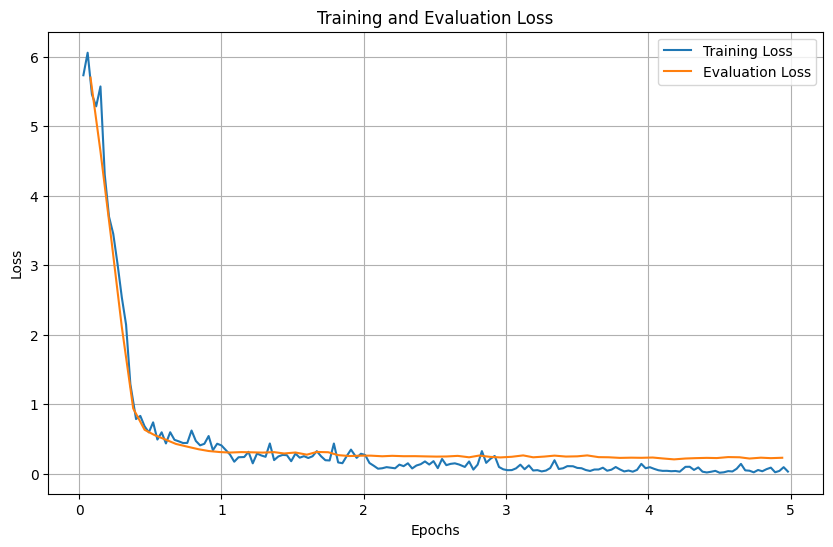

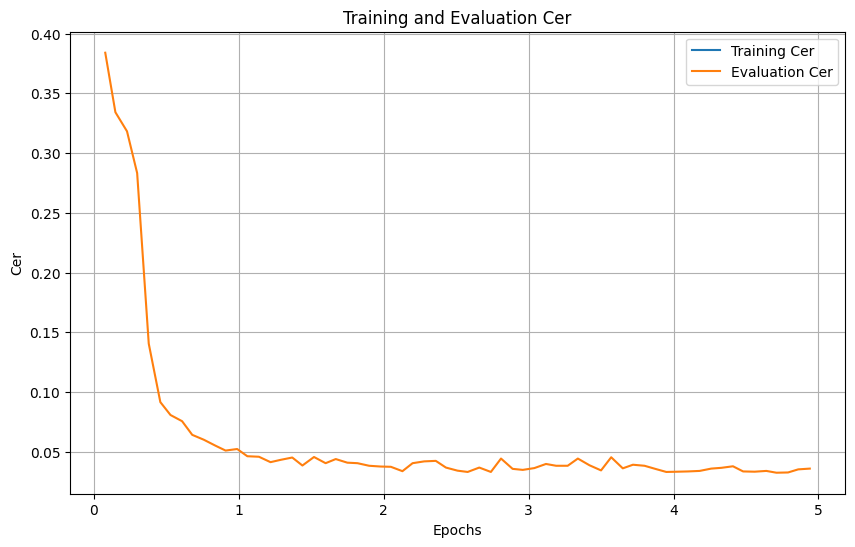

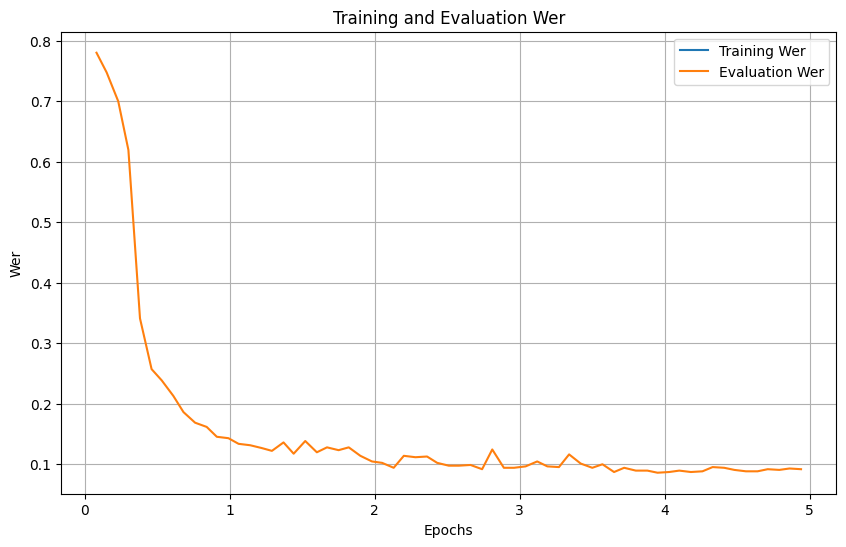

In [7]:
# Extract logs for plotting
train_logs = trainer.state.log_history

# Plotting the training and evaluation curves
def plot_metrics(logs, metric_name):
    train_steps = []
    train_values = []
    eval_steps = []
    eval_values = []

    for log in logs:
        if 'loss' in log and metric_name == 'loss':
            if 'epoch' in log:
                train_steps.append(log['epoch'])
                train_values.append(log['loss'])
        elif f'eval_{metric_name}' in log:
            if 'epoch' in log:
                eval_steps.append(log['epoch'])
                eval_values.append(log[f'eval_{metric_name}'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_values, label=f'Training {metric_name.capitalize()}')
    plt.plot(eval_steps, eval_values, label=f'Evaluation {metric_name.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training and Evaluation {metric_name.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot loss, CER, and WER
plot_metrics(train_logs, 'loss')
plot_metrics(train_logs, 'cer')
plot_metrics(train_logs, 'wer')

In [10]:
import re
import os
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model_path = "./trocr_finetuned"
# processor_path = "./trocr_finetuned"

# # Load the fine-tuned model and processor
# processor = TrOCRProcessor.from_pretrained(processor_path)
# model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

# Function to generate text for a single image segment
def generate_text_from_image_segment(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)  # Move pixel_values to the correct device
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Base directory where the page folders are located
base_dir = "dataset/test" 

def sort_key(filename):
    """
    Custom sort function to extract the segment number from the filename
    and use it as the key for sorting.
    """
    match = re.search(r"line_segment_(\d+)\.jpg", filename)
    if match:
        return int(match.group(1))
    return -1  # Return -1 if the pattern doesn't match

# Iterate through each page's folder
for page_folder in sorted(os.listdir(base_dir)):
    page_path = os.path.join(base_dir, page_folder)
    if os.path.isdir(page_path):
        print(f"Processing {page_folder}:")
        page_texts = []

        # Sort the line segment images numerically based on the segment number
        line_segment_images = sorted(os.listdir(page_path), key=sort_key)

        # Iterate through each sorted line segment in the page folder
        for line_segment_image in line_segment_images:
            if line_segment_image.endswith('.jpg'):
                line_segment_path = os.path.join(page_path, line_segment_image)
                line_text = generate_text_from_image_segment(line_segment_path)
                page_texts.append(line_text)
                print(f"  {line_segment_image}: {line_text}")

        # Compile and display the full page's text
        full_page_text = "\n".join(page_texts)
        print(f"\nFull text for {page_folder}:")
        print(full_page_text)
        print("\n" + "="*50 + "\n")


cuda
Processing 220:
  4.jpg: uno inconstante cessando, o necio si
  21.jpg: letras del Alphabeto, y no es me-
  3.jpg: zerlo assi, suele seguirse aver de ser
  13.jpg: en los poderosos es la fra como el
  14.jpg: bramido del Leon (del qual dizen
  15.jpg: los naturales) mata a los animales
  12.jpg: bres honray amor. Y el mesmo, que
  2.jpg: las circumstancias: porque de no ha-
  5.jpg: prosigue lo que no deviera empe-
  20.jpg: labras con la ira, dixesse entre si las
  18.jpg: Emperador Theodosio su dicipulo,
  11.jpg: sedumbre, y ganaras entre los hom-
  16.jpg: que le oyen. El remedio que aplico
  6.jpg: zar, como dixo Ciceron.
  23.jpg: sabio, que advierta en tales ocasio-
  24.jpg: nes, como Mecenas a Octaviano: pe
  1.jpg: stro gusto, considerando bien antes
  8.jpg: al buen gobierno, y autoridad, y assi
  9.jpg: tomareys el consejo del Eclesiasti-
  7.jpg: La colera demasiada, es opuesta
  22.jpg: nos importante tener un consejero
  17.jpg: para esta passion Libio Filosofo al
 

In [11]:
!nvidia-smi

Sat Jun  8 18:42:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
|  0%   41C    P8              15W / 320W |  14636MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
